In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")

import calendar


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats


from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations


from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder#, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../../src"))   
import soporte_preprocesamiento as f
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [2]:
df_sinnull=pd.read_csv("..\..\..\datos\datos0\datos_clusterizados0_sin_nulos.csv", index_col=0)


In [3]:
df_sinnull.head(2)

,Ship Mode,Segment,City,Country,Category,Sub-Category,Quantity,Discount,Order Priority,month,Sales_unitario
0,First Class,Consumer,Brisbane,Australia,Technology,Phones,entre 9 y 10,0.10,Medium,October,544.75
1,First Class,Home Office,Berlin,Germany,Technology,Phones,entre 5 y 6,0.10,Medium,January,525.91


In [4]:
df_sinnull.duplicated().sum()

0

In [5]:
df_sinnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9074 entries, 0 to 9073
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ship Mode       9074 non-null   object 
 1   Segment         9074 non-null   object 
 2   City            9074 non-null   object 
 3   Country         9074 non-null   object 
 4   Category        9074 non-null   object 
 5   Sub-Category    9074 non-null   object 
 6   Quantity        9074 non-null   object 
 7   Discount        9074 non-null   float64
 8   Order Priority  9074 non-null   object 
 9   month           9074 non-null   object 
 10  Sales_unitario  9074 non-null   float64
dtypes: float64(2), object(9)
memory usage: 850.7+ KB


Tenemos 9 columnas de categóricas

In [6]:
df_sinnull.nunique()

Ship Mode            4
Segment              3
City                48
Country             36
Category             3
Sub-Category        17
Quantity             8
Discount            23
Order Priority       4
month               12
Sales_unitario    7767
dtype: int64

In [7]:
df_categoricas=df_sinnull.select_dtypes("O")

In [8]:
df_categoricas.head()

,Ship Mode,Segment,City,Country,Category,Sub-Category,Quantity,Order Priority,month
0,First Class,Consumer,Brisbane,Australia,Technology,Phones,entre 9 y 10,Medium,October
1,First Class,Home Office,Berlin,Germany,Technology,Phones,entre 5 y 6,Medium,January
2,Second Class,Corporate,Sydney,Australia,Technology,Phones,entre 5 y 6,Critical,June
3,Second Class,Corporate,Paris,France,Office Supplies,Appliances,entre 3 y 4,Critical,July
4,First Class,Consumer,Soyapango,El Salvador,Furniture,Tables,entre 7 y 8,Critical,September


Ahora vamos a visualizar la relación entre la dependiente y las categóricas 

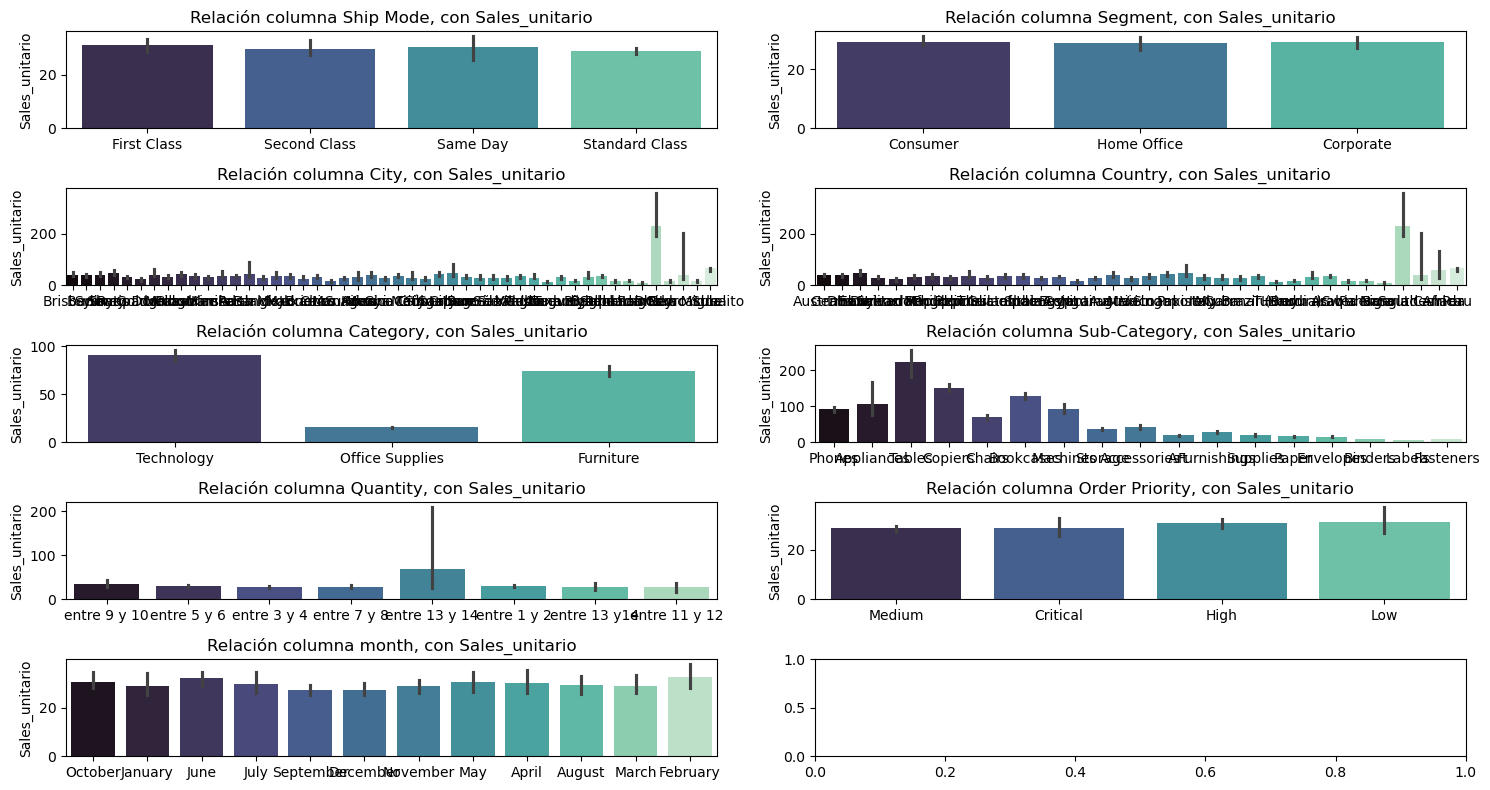

In [11]:
f.visualizar_categoricas(df_sinnull, "Sales_unitario", (15,8), tipo_graf="bar", bigote=1.5, metrica="median")

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

In [13]:
# llamamos a la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinnull, columna_numerica= "Sales_unitario")
print("\n-------------\n")
lista_col_categ=df_sinnull.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # llamamos la clase de test estadísticos para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinnull, "Sales_unitario", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable SHIP MODE
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Ship Mode las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['First Class', 'Second Class', 'Same Day', 'Standard Class']



Realizando test de Kruskal...
Estadístico de prueba: 1.961167502914812
Valor p: 0.5805055270844561
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-0.36,1.00,-13.83,13.11,First Class-Same Day
1,0.93,0.99,-8.46,10.31,First Class-Second Class
2,-0.96,0.99,-8.71,6.79,First Class-Standard Class
3,1.29,0.99,-11.88,14.45,Same Day-Second Class
4,-0.60,1.00,-12.66,11.46,Same Day-Standard Class
5,-1.89,0.91,-9.09,5.32,Second Class-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Home Office', 'Corporate']

Realizando test de Kruskal...
Estadístico de prueba: 0.15464882463101076
Valor p: 0.9255895322517909
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-1.09,0.89,-6.78,4.59,Consumer-Corporate
1,-2.90,0.56,-9.51,3.71,Consumer-Home Office
2,-1.81,0.83,-9.04,5.42,Corporate-Home Office



###########################

Estamos analizando la variable CITY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable City las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Brisbane', 'Berlin', 'Sydney', 'Paris', 'Soyapango', 'Santo Domingo', 'Gold Coast', 'London', 'Melbourne', 'Casablanca', 'Manila', 'Kinshasa', 'Perth', 'Adelaide', 'Bangkok', 'Mixco', 'Madrid', 'Jakarta', 'Cairo', 'Buenos Aires', 'Managua', 'Surabaya', 'Vienna', 'Mexico City', 'Ho Chi Minh City', 'León', 'Canberra', 'Singapore', 'Lahore', 'Rome', 'Santiago de Cuba', 'San Salvador', 'São Paulo', 'Yangon', 'Villa Nueva', 'Istanbul', 'Alexandria', 'Tegucigalpa', 'Riyadh', 'Baghdad', 'Stockholm', 'Panama City', 'Lagos', 'Dhaka', 'San Pedro Sula', 'Newcastle', 'San Miguelito', 'Lima']

Realizando test de Kruskal...
Estadístico de prueba: 727.7305918716161
Valor p: 7.849494230582179e-123
Hay una diferencia signi

,meandiff,p-adj,lower,upper,group_diff
0,-30.17,0.98,-82.00,21.67,Adelaide-Alexandria
1,-24.67,1.00,-70.99,21.64,Adelaide-Baghdad
2,-29.04,0.83,-71.44,13.37,Adelaide-Bangkok
3,-30.48,0.82,-74.83,13.87,Adelaide-Berlin
4,-10.72,1.00,-56.76,35.33,Adelaide-Brisbane
...,...,...,...,...,...
1123,27.50,0.98,-20.42,75.42,Tegucigalpa-Villa Nueva
1124,39.98,0.04,0.77,79.19,Tegucigalpa-Yangon
1125,-10.87,1.00,-60.87,39.12,Vienna-Villa Nueva
1126,1.61,1.00,-40.11,43.33,Vienna-Yangon



###########################

Estamos analizando la variable COUNTRY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Country las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Australia', 'Germany', 'France', 'El Salvador', 'Dominican Republic', 'United Kingdom', 'Morocco', 'Philippines', 'Democratic Republic of the Congo', 'Thailand', 'Guatemala', 'Spain', 'Indonesia', 'Egypt', 'Argentina', 'Nicaragua', 'Austria', 'Mexico', 'Vietnam', 'Singapore', 'Pakistan', 'Italy', 'Cuba', 'Brazil', 'Myanmar (Burma)', 'Turkey', 'Honduras', 'Saudi Arabia', 'Iraq', 'Sweden', 'Panama', 'Nigeria', 'Bangladesh', 'South Africa', 'Canada', 'Peru']

Realizando test de Kruskal...
Estadístico de prueba: 706.591939391104
Valor p: 4.987190987684572e-126
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,47.16,0.00,17.58,76.75,Argentina-Australia
1,32.33,0.21,-4.46,69.11,Argentina-Austria
2,233.50,0.00,88.43,378.58,Argentina-Bangladesh
3,29.87,0.67,-11.73,71.47,Argentina-Brazil
4,67.56,0.33,-14.21,149.32,Argentina-Canada
...,...,...,...,...,...
625,9.60,1.00,-22.78,41.98,Thailand-United Kingdom
626,-6.43,1.00,-42.34,29.47,Thailand-Vietnam
627,50.27,0.00,18.56,81.98,Turkey-United Kingdom
628,34.24,0.07,-1.07,69.54,Turkey-Vietnam



###########################

Estamos analizando la variable CATEGORY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Technology', 'Office Supplies', 'Furniture']

Realizando test de Kruskal...
Estadístico de prueba: 3499.186640064389
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-83.44,0.00,-89.17,-77.70,Furniture-Office Supplies
1,9.37,0.00,2.42,16.31,Furniture-Technology
2,92.80,0.00,87.14,98.47,Office Supplies-Technology



###########################

Estamos analizando la variable SUB-CATEGORY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Sub-Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Phones', 'Appliances', 'Tables', 'Copiers', 'Chairs', 'Bookcases', 'Machines', 'Storage', 'Accessories', 'Art', 'Furnishings', 'Supplies', 'Paper', 'Envelopes', 'Binders', 'Labels', 'Fasteners']

Realizando test de Kruskal...
Estadístico de prueba: 5919.945727296067
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,126.40,0.00,107.63,145.18,Accessories-Appliances
1,-39.88,0.00,-54.64,-25.13,Accessories-Art
2,-48.50,0.00,-62.83,-34.17,Accessories-Binders
3,103.41,0.00,86.86,119.96,Accessories-Bookcases
4,50.08,0.00,34.95,65.21,Accessories-Chairs
...,...,...,...,...,...
131,-126.23,0.00,-142.66,-109.80,Phones-Supplies
132,104.18,0.00,78.27,130.10,Phones-Tables
133,-36.24,0.00,-51.42,-21.07,Storage-Supplies
134,194.17,0.00,169.03,219.30,Storage-Tables



###########################

Estamos analizando la variable QUANTITY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Quantity las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['entre 9 y 10', 'entre 5 y 6', 'entre 3 y 4', 'entre 7 y 8', 'entre 13 y 14', 'entre 1 y 2', 'entre 13 y14', 'entre 11 y 12']

Realizando test de Kruskal...
Estadístico de prueba: 7.3345132813338685
Valor p: 0.39490072727230197
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-23.76,0.60,-63.26,15.73,entre 1 y 2-entre 11 y 12
1,40.72,0.90,-55.40,136.85,entre 1 y 2-entre 13 y 14
2,-4.07,1.00,-52.93,44.79,entre 1 y 2-entre 13 y14
3,-6.47,0.15,-13.96,1.03,entre 1 y 2-entre 3 y 4
4,3.34,0.96,-6.13,12.81,entre 1 y 2-entre 5 y 6
5,-1.72,1.00,-14.56,11.13,entre 1 y 2-entre 7 y 8
6,-4.43,1.00,-26.39,17.54,entre 1 y 2-entre 9 y 10
7,64.49,0.56,-39.20,168.18,entre 11 y 12-entre 13 y 14
8,19.69,0.98,-42.75,82.14,entre 11 y 12-entre 13 y14
9,17.30,0.89,-22.30,56.90,entre 11 y 12-entre 3 y 4



###########################

Estamos analizando la variable ORDER PRIORITY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Order Priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Medium', 'Critical', 'High', 'Low']

Realizando test de Kruskal...
Estadístico de prueba: 4.62381051011155
Valor p: 0.20150898615538257
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-5.60,0.58,-16.85,5.66,Critical-High
1,2.08,0.99,-13.20,17.36,Critical-Low
2,-7.72,0.25,-18.43,2.98,Critical-Medium
3,7.68,0.39,-4.83,20.19,High-Low
4,-2.13,0.81,-8.25,3.99,High-Medium
5,-9.80,0.15,-21.82,2.21,Low-Medium



###########################

Estamos analizando la variable MONTH
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable month las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['October', 'January', 'June', 'July', 'September', 'December', 'November', 'May', 'April', 'August', 'March', 'February']

Realizando test de Kruskal...
Estadístico de prueba: 9.999779017684595
Valor p: 0.5304070286843258
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,4.91,1.00,-12.94,22.76,April-August
1,2.45,1.00,-14.36,19.25,April-December
2,7.82,0.99,-13.72,29.36,April-February
3,3.21,1.00,-17.27,23.69,April-January
4,4.31,1.00,-14.92,23.53,April-July
...,...,...,...,...,...
61,-0.62,1.00,-17.53,16.29,May-October
62,-9.80,0.73,-26.30,6.70,May-September
63,4.48,1.00,-10.26,19.21,November-October
64,-4.70,1.00,-18.97,9.56,November-September



###########################



#### FIJANDONOS TANTO EN LAS VISUALIZACIONES COMO EN EL TEST DE TUKEY HEMOS OBTENIDO LAS SIGUIENTES CONCLUSIONES:  

**NO ORDENADAS:**
- SHIP MODE
- SEGMENT
- QUANTITY
- ORDER PRIORITY
- MONTH  
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- SUB-CATEGORY (entre casi todas)
- CITY  (entre algunas)
- COUNTRY (entre algunas)
- CATEGORY  (entre todas)
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [14]:
df_sinnull.columns

Index(['Ship Mode', 'Segment', 'City', 'Country', 'Category', 'Sub-Category',
       'Quantity', 'Discount', 'Order Priority', 'month', 'Sales_unitario'],
      dtype='object')

In [16]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment','Quantity','Order Priority', 'month'], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ['City', 'Country','Category', 'Sub-Category']  
                        }

In [15]:
df_sinnull.shape

(9074, 11)

In [ ]:
encoding=f.Encoding(dataframe = df_sinnull , diccionario_encoding= diccionario_encoding, variable_respuesta= "Sales_unitario")
df_sinnull= encoding.one_hot_encoding()
df_sinnull.head()
#nos genera 31 columnas nuevas aproximadamente

,Ship Mode,Segment,City,Country,Category,Sub-Category,Quantity,Discount,Order Priority,month,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,First Class,Consumer,Brisbane,Australia,Technology,Phones,entre 9 y 10,0.10,Medium,October,544.75,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,First Class,Home Office,Berlin,Germany,Technology,Phones,entre 5 y 6,0.10,Medium,January,525.91,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Second Class,Corporate,Sydney,Australia,Technology,Phones,entre 5 y 6,0.10,Critical,June,520.49,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,Second Class,Corporate,Paris,France,Office Supplies,Appliances,entre 3 y 4,0.10,Critical,July,534.17,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,First Class,Consumer,Soyapango,El Salvador,Furniture,Tables,entre 7 y 8,0.20,Critical,September,280.87,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [19]:
df_sinnull.shape

(9074, 42)

Aqui ya está codificada la de abtest en abtest_test vamos a por el resto

In [20]:
encoder_target= TargetEncoder(cols=['City', 'Country','Category', 'Sub-Category'])
encoded= encoder_target.fit_transform(df_sinnull , df_sinnull[["Sales_unitario"]])
lista_eliminar=['Ship Mode', 'Segment','Quantity','Order Priority', 'month']
encoded.drop(columns=lista_eliminar, inplace=True)


In [21]:
encoded.head(2)

,City,Country,Category,Sub-Category,Discount,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,90.69,90.75,126.04,149.03,0.10,544.75,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,70.93,70.93,126.04,149.03,0.10,525.91,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [22]:
encoded.columns

Index(['City', 'Country', 'Category', 'Sub-Category', 'Discount',
       'Sales_unitario', 'Ship Mode_First Class', 'Ship Mode_Same Day',
       'Ship Mode_Second Class', 'Ship Mode_Standard Class',
       'Segment_Consumer', 'Segment_Corporate', 'Segment_Home Office',
       'Quantity_entre 1 y 2', 'Quantity_entre 11 y 12',
       'Quantity_entre 13 y 14', 'Quantity_entre 13 y14',
       'Quantity_entre 3 y 4', 'Quantity_entre 5 y 6', 'Quantity_entre 7 y 8',
       'Quantity_entre 9 y 10', 'Order Priority_Critical',
       'Order Priority_High', 'Order Priority_Low', 'Order Priority_Medium',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September'],
      dtype='object')

TENGO QUE REVISAR PORQUE ME HA GENERADO NAN EN MONTCREATED

In [23]:
encoded.head()

,City,Country,Category,Sub-Category,Discount,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,90.69,90.75,126.04,149.03,0.10,544.75,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,70.93,70.93,126.04,149.03,0.10,525.91,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,93.16,90.75,126.04,149.03,0.10,520.49,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,89.53,89.53,33.24,190.20,0.10,534.17,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,70.38,72.33,116.67,253.21,0.20,280.87,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [24]:
encoded.to_csv("..\..\..\datos\datos0\datos_clusterizados0_encoded.csv")